In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd  # 版本会提示出错
import matplotlib.pyplot as plt
import pickle
import tqdm
import json
import time
import os
import math

/usr/local/anaconda3/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## 指定城市 指定时间
  

In [2]:
specific_area = 'boston'
# newyork la chicago houston phoenix philadelphia  sanantonio sandiego dallas sanjose
specific_period = '2019'
#比如2019年

filtdata_dir = '/data2/fanbingbing/'+specific_area+'/data/filt_safegraph/'
normdata_dir = '/data2/fanbingbing/'+specific_area+'/data/normalized_safegraph/'

## 指定城市：cbg地理和人口统计数据获取

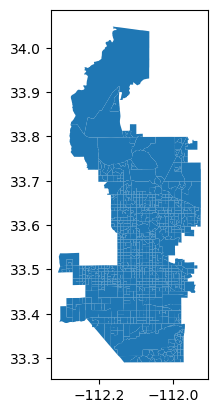

972


In [3]:
specific_geojson = gpd.read_file('/data2/zhangyunke/utils/city_geojson/'+specific_area+'.geojson')
specific_geojson.plot()
plt.show()
specific_cbgs = list(specific_geojson.census_block_group)
print(len(specific_cbgs))# 559 boston 2182chicago 1336philadelphia 1568houston

## CBG的人口属性数据获取处理

In [5]:
# 这个表格存储了美国各个CBG2019年的人口统计数据
cbg_features = pd.read_csv('/data2/zhangyunke/utils/cbg_features.csv')
# 取出指定范围内的CBG并分配其所处的收入等级 
specific_features = cbg_features[cbg_features.census_block_group.isin(specific_cbgs)]
specific_features = specific_features[specific_features['Total population'] >= 100] 
# 去掉人口太少的CBG（rural的地方） chicago2170 
specific_features['average_income_group'] = pd.qcut(specific_features.average_income, 4, labels = [0,1,2,3])
specific_features.to_csv('/data2/fanbingbing/' + specific_area + '/' + specific_area +'_cbg_data.csv',index = False)

# 可视化一下区域里面平均收入的分布
# pd.merge(specific_geojson, specific_features, on = 'census_block_group').plot(figsize = (10, 10), column = 'average_income_group', cmap = 'YlGn', legend = True)
# print(specific_features.columns)
print(specific_features.shape)
specific_features 

(970, 32)


,census_block_group,Total population,Households total,female_ratio,white_ratio,black_ratio,asian_ratio,Hispanic_ratio,non_Hispanic_white_ratio,non_Hispanic_black_ratio,...,no_health_insurance_ratio,single_family_ratio,driving_ratio,public_transit_ratio,average_commuting_time,leave_home_time,average_household_size,children_rate,vehicle_rate,average_income_group
4677,40130820021,2241,658,0.434181,0.660866,0.059349,0.006247,0.567604,0.351629,0.059349,...,0.109772,0.811842,0.950920,0.000000,31.706989,9.083602,3.156535,1.381930,0.969605,2
4678,40130820022,2171,801,0.529710,0.820359,0.105942,0.034086,0.448181,0.411792,0.105942,...,0.144115,0.420000,0.959932,0.000000,24.316163,8.360568,2.483146,1.082828,0.982522,1
4679,40130820023,2154,618,0.437326,0.675023,0.063138,0.000000,0.543175,0.393686,0.063138,...,0.413185,0.658576,0.958005,0.000000,26.953125,8.893527,3.118123,0.761111,1.000000,1
4680,40130820071,2321,681,0.478242,0.502370,0.010771,0.008617,0.708315,0.224041,0.010771,...,0.249031,0.620174,0.918274,0.004591,33.250235,7.693086,3.054332,1.059150,0.879589,1
4681,40130820072,1657,513,0.508751,0.680748,0.006035,0.018709,0.799638,0.194327,0.006035,...,0.224848,0.920904,0.961776,0.000000,29.162500,7.540938,2.980507,0.720317,1.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6621,40136198003,1357,489,0.585851,0.611643,0.022845,0.178335,0.142962,0.574797,0.022845,...,0.000000,0.981061,0.853511,0.000000,25.723870,8.812500,2.597137,0.783715,1.000000,2
6622,40136199001,1272,488,0.541667,0.855346,0.000000,0.127358,0.060535,0.794811,0.000000,...,0.000000,1.000000,0.875000,0.000000,21.401099,7.917582,2.524590,0.991501,0.971311,3
6623,40136199002,1614,677,0.466543,0.576208,0.010533,0.387856,0.052045,0.549566,0.010533,...,0.028501,0.409836,0.792793,0.046332,23.059816,8.215874,2.361891,1.271540,0.961595,3
6624,40136199003,1632,618,0.417892,0.839461,0.011642,0.031250,0.136642,0.784926,0.011642,...,0.018382,0.823625,0.938107,0.000000,21.084071,8.492415,2.423948,0.909091,1.000000,3


## POI SafeGraph数据获取处理

# 读取数据

In [ ]:
# 2018.1~2022.4的数据位于这个路径
safegraph_dir = '/data2/Datasets/SafeGraphDatasets/SafeGraph_new/'
files = os.listdir(safegraph_dir)
files = [x for x in files if 'patterns-' in x] #取出原始数据中我们需要的pattterns文件数据（有poi信息）
months = sorted(set([x[9:16] for x in files])) #取出所有数据含有的月份
specific_month = [x for x in months if specific_period in x] #取出想找的年份的月份
specific_month_files = sorted([x for x in files for month in specific_month if month in x and 'part' in x]) #取出有这个月份的文件
# print(specific_month_files)  #48个 每个月四个part 每个月POI有重复但不完全一致 


# cbg-->poi人数优化

In [7]:
# 筛选特定城市POI (运行一次即可）
# 将SafeGraph中的原始文件进行城市内poi的筛选（顺带计算归一化系数），筛选后的poi保存在filt_safegraph文件夹中
for x in specific_month_files: 
    print(x)
    df = pd.read_csv(safegraph_dir+x)
    print(df.shape)
    specific_filt_poi_df = df[df.poi_cbg.isin(specific_cbgs)] #筛选特定城市
    specific_filt_poi_df['norm'] = specific_filt_poi_df.normalized_visits_by_state_scaling / specific_filt_poi_df.raw_visitor_counts
    print(specific_filt_poi_df.shape)
    specific_filt_poi_df.to_csv(filtdata_dir+'filt_'+ specific_area + '_' +x,index=False)

patterns-2019-01-part1.csv
(1221572, 44)
(5667, 45)


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


patterns-2019-01-part2.csv
(1224333, 44)
(5526, 45)
patterns-2019-01-part3.csv


/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(1211456, 44)
(5464, 45)
patterns-2019-01-part4.csv
(1149607, 44)
(5073, 45)
patterns-2019-02-part1.csv
(1218031, 44)
(5618, 45)
patterns-2019-02-part2.csv
(1220771, 44)
(5517, 45)
patterns-2019-02-part3.csv
(1207833, 44)
(5530, 45)
patterns-2019-02-part4.csv
(1145433, 44)
(5038, 45)
patterns-2019-03-part1.csv
(1229163, 44)
(5667, 45)
patterns-2019-03-part2.csv
(1232040, 44)
(5556, 45)
patterns-2019-03-part3.csv
(1218986, 44)
(5492, 45)
patterns-2019-03-part4.csv
(1157161, 44)
(5081, 45)
patterns-2019-04-part1.csv
(1233139, 44)
(5662, 45)
patterns-2019-04-part2.csv
(1236542, 44)
(5554, 45)
patterns-2019-04-part3.csv
(1222823, 44)
(5478, 45)
patterns-2019-04-part4.csv
(1163190, 44)
(5084, 45)
patterns-2019-05-part1.csv
(1237842, 44)
(5654, 45)
patterns-2019-05-part2.csv
(1240660, 44)
(5546, 45)
patterns-2019-05-part3.csv
(1227337, 44)
(5492, 45)
patterns-2019-05-part4.csv
(1169227, 44)
(5072, 45)
patterns-2019-06-part1.csv
(1232576, 44)
(5607, 45)
patterns-2019-06-part2.csv
(1235561, 44

/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (1,3,4,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(1163371, 44)
(5039, 45)
patterns-2019-07-part1.csv
(1228129, 44)
(5566, 45)
patterns-2019-07-part2.csv
(1230901, 44)
(5489, 45)
patterns-2019-07-part3.csv
(1217882, 44)
(5450, 45)
patterns-2019-07-part4.csv
(1158598, 44)
(5030, 45)
patterns-2019-08-part1.csv
(1229117, 44)
(5603, 45)
patterns-2019-08-part2.csv
(1232003, 44)
(5504, 45)
patterns-2019-08-part3.csv
(1218470, 44)
(5482, 45)
patterns-2019-08-part4.csv
(1159359, 44)
(5029, 45)
patterns-2019-09-part1.csv
(1227728, 44)
(5623, 45)
patterns-2019-09-part2.csv
(1230516, 44)
(5511, 45)
patterns-2019-09-part3.csv
(1217373, 44)
(5458, 45)
patterns-2019-09-part4.csv
(1157408, 44)
(5034, 45)
patterns-2019-10-part1.csv
(1226326, 44)
(5634, 45)
patterns-2019-10-part2.csv


/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(1228824, 44)
(5525, 45)
patterns-2019-10-part3.csv
(1215856, 44)
(5462, 45)
patterns-2019-10-part4.csv
(1156057, 44)
(5048, 45)
patterns-2019-11-part1.csv
(1221129, 44)
(5585, 45)
patterns-2019-11-part2.csv
(1223543, 44)
(5506, 45)
patterns-2019-11-part3.csv
(1210592, 44)
(5457, 45)
patterns-2019-11-part4.csv
(1150263, 44)
(5047, 45)
patterns-2019-12-part1.csv
(1224687, 44)
(5484, 45)
patterns-2019-12-part2.csv
(1227134, 44)
(5426, 45)
patterns-2019-12-part3.csv
(1214561, 44)
(5460, 45)
patterns-2019-12-part4.csv
(1153746, 44)
(5041, 45)


In [8]:
 # cbg-->poi人数优化 执行一次即可
# 将filt_safegraph的城市内poi数据进行flows的筛选，只保留城市内的flows，同时归一化，之后结果保存在normalized_safegraph中

for x in specific_month_files:
    print(x)
    specific_norm_poi_df = pd.read_csv(filtdata_dir+'filt_'+ specific_area + '_' +x)
    for index, row in specific_norm_poi_df.iterrows():
        temp_dict = json.loads(row['visitor_home_cbgs'])  
        temp_dict = {key: value for key, value in temp_dict.items() if key.isdigit()}
        # 清洗非全数值的CBG编号（不在美国内，不会影响结果）
        temp_dict = {key: value for key, value in temp_dict.items() if int(key) in specific_cbgs}
        
        temp_dict = {key: value * row['norm'] for key, value in temp_dict.items()}
         # 使用 at 方法在 DataFrame 中设置值
        specific_norm_poi_df.at[index, 'visitor_home_cbgs'] = json.dumps(temp_dict)
    # print(specific_norm_poi_df.shape)
    specific_norm_poi_df.to_csv(normdata_dir+'normalized_'+ specific_area + '_' +x,index=False)

patterns-2019-01-part1.csv
patterns-2019-01-part2.csv
patterns-2019-01-part3.csv
patterns-2019-01-part4.csv
patterns-2019-02-part1.csv
patterns-2019-02-part2.csv
patterns-2019-02-part3.csv
patterns-2019-02-part4.csv
patterns-2019-03-part1.csv
patterns-2019-03-part2.csv
patterns-2019-03-part3.csv
patterns-2019-03-part4.csv
patterns-2019-04-part1.csv
patterns-2019-04-part2.csv
patterns-2019-04-part3.csv
patterns-2019-04-part4.csv
patterns-2019-05-part1.csv
patterns-2019-05-part2.csv
patterns-2019-05-part3.csv
patterns-2019-05-part4.csv
patterns-2019-06-part1.csv
patterns-2019-06-part2.csv
patterns-2019-06-part3.csv
patterns-2019-06-part4.csv
patterns-2019-07-part1.csv
patterns-2019-07-part2.csv
patterns-2019-07-part3.csv
patterns-2019-07-part4.csv
patterns-2019-08-part1.csv
patterns-2019-08-part2.csv
patterns-2019-08-part3.csv
patterns-2019-08-part4.csv
patterns-2019-09-part1.csv
patterns-2019-09-part2.csv
patterns-2019-09-part3.csv
patterns-2019-09-part4.csv
patterns-2019-10-part1.csv
p

**合并符合时间条件的、非空home_cbgs的visitor_home_cbgs数据**


In [9]:
# 合并两个字典的值，相同相加，不同直接append
def merge_dicts(dict1, dict2):
    merged_dict = dict1.copy()
    for key, value in dict2.items():
        if key in merged_dict:
            merged_dict[key] += value
        else:
            merged_dict[key] = value
    return merged_dict #dict

In [10]:
#更新df2的visitor_home_cbgs
def update_dataframes(df1, df2):
    merged_rows = []
    # matching_row = pd.Series
    for index, row in tqdm.tqdm(df2.iterrows()):
        placekey = row['placekey']
        if placekey in df1['placekey'].values:
            matching_row = df1[df1['placekey'] == placekey].iloc[0].copy() #这样 matching_row和row都是series形式了
            dict_temp = merge_dicts(matching_row['visitor_home_cbgs'], row['visitor_home_cbgs'])
            matching_row['visitor_home_cbgs']= dict_temp
            merged_rows.append(matching_row.to_frame().T)
        else:
            row = pd.DataFrame(row).transpose()
            merged_rows.append(row)
            
    # print(merged_rows)
    merged_df = pd.concat(merged_rows,ignore_index=True)
    # print(merged_df)
    return merged_df

In [11]:
# 合并符合时间条件的、非空的home_cbgs，生成的specific_poi_dfs.csv文件包含placekey和visitor_home_cbgs两列
# BostonMSAPOI数量70729个
# specific_month_files=['patterns-2019-01-part1.csv','patterns-2019-01-part1.csv']
specific_poi_dfs = pd.DataFrame()
for x in specific_month_files: 
    print(x)
    #依次读入48个文件
    specific_poi_df = pd.read_csv(normdata_dir+'normalized_'+ specific_area + '_' +x,usecols=['placekey','visitor_home_cbgs'])
    
    specific_poi_df['visitor_home_cbgs'] = specific_poi_df['visitor_home_cbgs'].map(lambda x: json.loads(x)) 
    specific_poi_df = specific_poi_df[specific_poi_df['visitor_home_cbgs'].apply(lambda x: len(x) > 0)]#清洗空字典
    specific_poi_df = specific_poi_df.reset_index(drop=True)
    
    if specific_poi_dfs.empty:
        specific_poi_dfs = specific_poi_df
    else:
        # 对新的df数据每行应用更新函数
        specific_poi_df_temp = update_dataframes(specific_poi_dfs, specific_poi_df)
        
        # 原始specific_poi_dfs和处理过的specific_poi_df_temp进行合并
        specific_poi_dfs = specific_poi_df_temp.merge(specific_poi_dfs, on=['placekey'], how='outer',suffixes=('_temp', '_old')) 
        specific_poi_dfs['visitor_home_cbgs'] = specific_poi_dfs['visitor_home_cbgs_temp'].fillna(specific_poi_dfs['visitor_home_cbgs_old'])
        specific_poi_dfs = specific_poi_dfs.drop(['visitor_home_cbgs_old','visitor_home_cbgs_temp'], axis=1)
        # specific_poi_dfs = specific_poi_dfs[specific_poi_dfs['visitor_home_cbgs'].apply(lambda x: len(x) > 0)] #想起来这里应该清洗一下空字典，但还没调试
    
    print(specific_poi_dfs.shape)
    
specific_poi_dfs['visitor_home_cbgs'] = specific_poi_dfs.visitor_home_cbgs.map(lambda x: json.dumps(x))
specific_poi_dfs.to_csv('/data2/fanbingbing/'+specific_area+'/data/'+specific_area+'_poi_visitor.csv',index=False) #这个文件是合并了之后的placekey和home_cbgs

patterns-2019-01-part1.csv
(4840, 2)
patterns-2019-01-part2.csv


4749it [00:02, 1712.28it/s]


(9589, 2)
patterns-2019-01-part3.csv


4675it [00:02, 1567.52it/s]


(14264, 2)
patterns-2019-01-part4.csv


4330it [00:03, 1320.89it/s]


(18594, 2)
patterns-2019-02-part1.csv


4785it [00:10, 452.02it/s]


(18917, 2)
patterns-2019-02-part2.csv


4716it [00:10, 443.86it/s]


(19252, 2)
patterns-2019-02-part3.csv


4714it [00:10, 432.18it/s]


(19632, 2)
patterns-2019-02-part4.csv


4336it [00:10, 425.55it/s]


(19934, 2)
patterns-2019-03-part1.csv


4897it [00:12, 406.68it/s]


(20106, 2)
patterns-2019-03-part2.csv


4774it [00:11, 407.44it/s]


(20254, 2)
patterns-2019-03-part3.csv


4685it [00:11, 404.65it/s]


(20428, 2)
patterns-2019-03-part4.csv


4356it [00:10, 402.15it/s]


(20574, 2)
patterns-2019-04-part1.csv


4868it [00:12, 393.73it/s]


(20690, 2)
patterns-2019-04-part2.csv


4776it [00:12, 389.03it/s]


(20787, 2)
patterns-2019-04-part3.csv


4722it [00:12, 389.78it/s]


(20895, 2)
patterns-2019-04-part4.csv


4319it [00:11, 388.45it/s]


(20968, 2)
patterns-2019-05-part1.csv


4883it [00:12, 385.35it/s]


(21041, 2)
patterns-2019-05-part2.csv


4764it [00:12, 382.11it/s]


(21110, 2)
patterns-2019-05-part3.csv


4739it [00:12, 382.39it/s]


(21185, 2)
patterns-2019-05-part4.csv


4364it [00:11, 383.07it/s]


(21250, 2)
patterns-2019-06-part1.csv


4783it [00:12, 376.36it/s]


(21285, 2)
patterns-2019-06-part2.csv


4695it [00:12, 378.51it/s]


(21329, 2)
patterns-2019-06-part3.csv


4641it [00:12, 379.01it/s]


(21375, 2)
patterns-2019-06-part4.csv


4277it [00:11, 377.73it/s]


(21419, 2)
patterns-2019-07-part1.csv


4738it [00:12, 373.38it/s]


(21445, 2)
patterns-2019-07-part2.csv


4692it [00:12, 370.18it/s]


(21480, 2)
patterns-2019-07-part3.csv


4577it [00:12, 375.07it/s]


(21520, 2)
patterns-2019-07-part4.csv


4267it [00:11, 374.89it/s]


(21552, 2)
patterns-2019-08-part1.csv


4803it [00:12, 372.73it/s]


(21590, 2)
patterns-2019-08-part2.csv


4733it [00:12, 372.10it/s]


(21626, 2)
patterns-2019-08-part3.csv


4653it [00:12, 373.04it/s]


(21663, 2)
patterns-2019-08-part4.csv


4325it [00:11, 369.58it/s]


(21697, 2)
patterns-2019-09-part1.csv


4850it [00:13, 364.14it/s]


(21726, 2)
patterns-2019-09-part2.csv


4788it [00:13, 367.02it/s]


(21754, 2)
patterns-2019-09-part3.csv


4688it [00:13, 341.48it/s]


(21780, 2)
patterns-2019-09-part4.csv


4328it [00:12, 343.98it/s]


(21817, 2)
patterns-2019-10-part1.csv


4864it [00:13, 364.90it/s]


(21839, 2)
patterns-2019-10-part2.csv


4779it [00:13, 363.98it/s]


(21862, 2)
patterns-2019-10-part3.csv


4722it [00:13, 363.20it/s]


(21896, 2)
patterns-2019-10-part4.csv


4362it [00:12, 361.90it/s]


(21917, 2)
patterns-2019-11-part1.csv


4781it [00:13, 361.74it/s]


(21939, 2)
patterns-2019-11-part2.csv


4708it [00:13, 355.45it/s]


(21958, 2)
patterns-2019-11-part3.csv


4612it [00:12, 357.54it/s]


(21981, 2)
patterns-2019-11-part4.csv


4316it [00:12, 358.21it/s]


(22000, 2)
patterns-2019-12-part1.csv


4724it [00:13, 354.57it/s]


(22015, 2)
patterns-2019-12-part2.csv


4688it [00:13, 359.58it/s]


(22029, 2)
patterns-2019-12-part3.csv


4668it [00:16, 286.39it/s]


(22039, 2)
patterns-2019-12-part4.csv


4331it [00:12, 353.81it/s]


(22061, 2)


## 计算segregation

In [12]:
# 将 specific_poi_dfs 中每行POI的‘visitor_home_cbgs_dict' 按照CBG编号
# 和 specific_features 中每行CBG的 ’average_income_group‘收入等级匹配
# 不在area范围内和缺失数据的用NaN表示 nanmean()计算均值时忽略

#可以用读入的），读入比较好不会因为调试乱了
specific_features = pd.read_csv('/data2/fanbingbing/' + specific_area + '/' + specific_area +'_cbg_data.csv')
specific_poi_dfs = pd.read_csv('/data2/fanbingbing/'+specific_area+'/data/'+specific_area+'_poi_visitor.csv')
specific_poi_dfs 
#boston 9479 chicago 37309 philadelphia 20509 Houston 50604 phoenix 22061

,placekey,visitor_home_cbgs
0,222-222@5zb-wvj-yqf,"{""040136169002"": 5782.655303050577, ""040136193..."
1,222-222@5zb-wwc-q9f,"{""040136185003"": 232.83678635507988, ""04013111..."
2,222-222@5zb-xbd-fj9,"{""040131169001"": 362.0694289136077, ""040131162..."
3,222-222@5zb-xc8-j9z,"{""040131086023"": 4457.404079506717, ""040131066..."
4,222-222@5zb-xcv-jsq,"{""040131145003"": 1833.6525557444804, ""04013114..."
...,...,...
22056,229-223@8ts-d2j-dd9,"{""040131167042"": 725.1961931129952}"
22057,zzw-226@5zb-xn7-dn5,"{""040131032091"": 60.4330160927496}"
22058,224-223@5zb-x3y-s3q,"{""040136126002"": 60.43301609274962}"
22059,225-223@8ts-d6b-2kz,"{""040131096012"": 60.43301609274962}"


In [13]:
def update_dict(row):
    new_dict = row['visitor_home_cbgs'].copy() # 要加copy否则会同时修改
    for key, value in new_dict.items():
        if int(key) in specific_features['census_block_group'].values:
            new_dict[key] = specific_features.loc[specific_features['census_block_group'] == int(key), 'average_income_group'].values[0]
        else:
            new_dict[key] = np.nan
    return new_dict

specific_poi_dfs['visitor_home_cbgs'] = specific_poi_dfs.visitor_home_cbgs.map(lambda x: json.loads(x))
specific_poi_dfs['visitor_home_cbgs_income_level'] = specific_poi_dfs.apply(lambda row:update_dict(row), axis=1)
specific_poi_dfs

,placekey,visitor_home_cbgs,visitor_home_cbgs_income_level
0,222-222@5zb-wvj-yqf,"{'040136169002': 5782.655303050577, '040136193...","{'040136169002': 3.0, '040136193003': 1.0, '04..."
1,222-222@5zb-wwc-q9f,"{'040136185003': 232.83678635507988, '04013111...","{'040136185003': 0.0, '040131118003': 3.0, '04..."
2,222-222@5zb-xbd-fj9,"{'040131169001': 362.0694289136077, '040131162...","{'040131169001': 0.0, '040131162022': 1.0, '04..."
3,222-222@5zb-xc8-j9z,"{'040131086023': 4457.404079506717, '040131066...","{'040131086023': 1.0, '040131066002': 3.0, '04..."
4,222-222@5zb-xcv-jsq,"{'040131145003': 1833.6525557444804, '04013114...","{'040131145003': 0.0, '040131145001': 0.0, '04..."
...,...,...,...
22056,229-223@8ts-d2j-dd9,{'040131167042': 725.1961931129952},{'040131167042': 2.0}
22057,zzw-226@5zb-xn7-dn5,{'040131032091': 60.4330160927496},{'040131032091': 3.0}
22058,224-223@5zb-x3y-s3q,{'040136126002': 60.43301609274962},{'040136126002': 3.0}
22059,225-223@8ts-d6b-2kz,{'040131096012': 60.43301609274962},{'040131096012': 0.0}


In [14]:
# 将visitor_home_cbg_income_level中相同level的visitor人数求和
# 保存在visitor_home_cbg_income_proportion中
def calculate_total_people(row):
    # print(row.name)
    income_level = row['visitor_home_cbgs_income_level']
    visitor_number = row['visitor_home_cbgs']
    people_sum = {'sum': 0,'level_0':0,'level_1':0,'level_2':0,'level_3':0}
    people_sum_keys_list = list(people_sum.keys())
    
    for keyl, valuel in income_level.items():
        if not math.isnan(valuel):  #如果，先计算总数，然后对应类别加人数
            for keyn, valuen in visitor_number.items():
                if keyn == keyl:  # 这里假设将满足特定条件的键为'sum'的值相加
                    people_sum['sum'] += valuen
                    people_sum[people_sum_keys_list[int(valuel)+1]] += valuen
    return people_sum

specific_poi_dfs['visitor_home_cbgs_income_proportion'] = specific_poi_dfs.apply(calculate_total_people, axis=1)
specific_poi_dfs

,placekey,visitor_home_cbgs,visitor_home_cbgs_income_level,visitor_home_cbgs_income_proportion
0,222-222@5zb-wvj-yqf,"{'040136169002': 5782.655303050577, '040136193...","{'040136169002': 3.0, '040136193003': 1.0, '04...","{'sum': 84956.41587911133, 'level_0': 6850.953..."
1,222-222@5zb-wwc-q9f,"{'040136185003': 232.83678635507988, '04013111...","{'040136185003': 0.0, '040131118003': 3.0, '04...","{'sum': 2666.1796549238106, 'level_0': 739.324..."
2,222-222@5zb-xbd-fj9,"{'040131169001': 362.0694289136077, '040131162...","{'040131169001': 0.0, '040131162022': 1.0, '04...","{'sum': 1155.083364300541, 'level_0': 362.0694..."
3,222-222@5zb-xc8-j9z,"{'040131086023': 4457.404079506717, '040131066...","{'040131086023': 1.0, '040131066002': 3.0, '04...","{'sum': 9951.751681984684, 'level_0': 1176.193..."
4,222-222@5zb-xcv-jsq,"{'040131145003': 1833.6525557444804, '04013114...","{'040131145003': 0.0, '040131145001': 0.0, '04...","{'sum': 4737.924530935405, 'level_0': 3620.785..."
...,...,...,...,...
22056,229-223@8ts-d2j-dd9,{'040131167042': 725.1961931129952},{'040131167042': 2.0},"{'sum': 725.1961931129952, 'level_0': 0, 'leve..."
22057,zzw-226@5zb-xn7-dn5,{'040131032091': 60.4330160927496},{'040131032091': 3.0},"{'sum': 60.4330160927496, 'level_0': 0, 'level..."
22058,224-223@5zb-x3y-s3q,{'040136126002': 60.43301609274962},{'040136126002': 3.0},"{'sum': 60.43301609274962, 'level_0': 0, 'leve..."
22059,225-223@8ts-d6b-2kz,{'040131096012': 60.43301609274962},{'040131096012': 0.0},"{'sum': 60.43301609274962, 'level_0': 60.43301..."


In [15]:
 # 计算segregation_index : 2/3* (sum of |por_1234 - 0.25|)
def calculate_segregation_index(row):
    people_sum = row['visitor_home_cbgs_income_proportion']
    people_sum_keys_list = list(people_sum.keys())
    segregation_index = float(0)
    sumnumber = people_sum[people_sum_keys_list[0]]
    if sumnumber != 0: #因为有缺失的
        for key_index in range(1, len(people_sum_keys_list)):  # 从第二个键值开始遍历
            key = people_sum_keys_list[key_index]
            value = people_sum[key]
            segregation_index += abs(value/sumnumber-0.25)
        segregation_index *= 2/3
    else:
        segregation_index = np.nan
    return segregation_index


specific_poi_dfs['segregation_index'] = specific_poi_dfs.apply(calculate_segregation_index,axis=1)
specific_poi_dfs

,placekey,visitor_home_cbgs,visitor_home_cbgs_income_level,visitor_home_cbgs_income_proportion,segregation_index
0,222-222@5zb-wvj-yqf,"{'040136169002': 5782.655303050577, '040136193...","{'040136169002': 3.0, '040136193003': 1.0, '04...","{'sum': 84956.41587911133, 'level_0': 6850.953...",0.225812
1,222-222@5zb-wwc-q9f,"{'040136185003': 232.83678635507988, '04013111...","{'040136185003': 0.0, '040131118003': 3.0, '04...","{'sum': 2666.1796549238106, 'level_0': 739.324...",0.065788
2,222-222@5zb-xbd-fj9,"{'040131169001': 362.0694289136077, '040131162...","{'040131169001': 0.0, '040131162022': 1.0, '04...","{'sum': 1155.083364300541, 'level_0': 362.0694...",0.152943
3,222-222@5zb-xc8-j9z,"{'040131086023': 4457.404079506717, '040131066...","{'040131086023': 1.0, '040131066002': 3.0, '04...","{'sum': 9951.751681984684, 'level_0': 1176.193...",0.448616
4,222-222@5zb-xcv-jsq,"{'040131145003': 1833.6525557444804, '04013114...","{'040131145003': 0.0, '040131145001': 0.0, '04...","{'sum': 4737.924530935405, 'level_0': 3620.785...",0.685618
...,...,...,...,...,...
22056,229-223@8ts-d2j-dd9,{'040131167042': 725.1961931129952},{'040131167042': 2.0},"{'sum': 725.1961931129952, 'level_0': 0, 'leve...",1.000000
22057,zzw-226@5zb-xn7-dn5,{'040131032091': 60.4330160927496},{'040131032091': 3.0},"{'sum': 60.4330160927496, 'level_0': 0, 'level...",1.000000
22058,224-223@5zb-x3y-s3q,{'040136126002': 60.43301609274962},{'040136126002': 3.0},"{'sum': 60.43301609274962, 'level_0': 0, 'leve...",1.000000
22059,225-223@8ts-d6b-2kz,{'040131096012': 60.43301609274962},{'040131096012': 0.0},"{'sum': 60.43301609274962, 'level_0': 60.43301...",1.000000


In [16]:
specific_poi_dfs.to_csv('/data2/fanbingbing/' + specific_area + '/' + specific_area+specific_period + '_segregationindex_includingoneflow.csv',index = False)

In [17]:
# # 可视化segregation index 要在运行create_datasets_vector之后运行
# 
# specific_poi_dfs=pd.read_csv('/data2/fanbingbing/' + specific_area + '/' + specific_area+specific_period + '_segregationindex_includingoneflow.csv')
# specific_poi_locations = pd.read_csv('/data2/fanbingbing/‘+specific_area+'/datasets/'+specific_area+'_poi_location.csv')
# boston_plot = pd.merge(specific_poi_dfs,poi_locations,on = 'placekey')
# 
# plt.figure(figsize = (15, 15))
# specific_geojson.plot()
# plt.scatter(boston_plot.longitude, boston_plot.latitude,c=boston_plot['segregation_index'],cmap = 'YlGn', s = 0.2)
# plt.colorbar()
# plt.show()  